# Filtrado inverso

En este notebook vamos a intentar deshacer una convolución trabajando en el dominio de la frecuencia.

## Bibliotecas y funciones auxiliares

In [1]:
import numpy             as np
import numpy.fft         as fft
import scipy.linalg      as la
import cv2               as cv
import skimage           as si
import matplotlib.pyplot as plt
import numpy.random      as rnd
import scipy.signal      as signal
from matplotlib.pyplot import imshow, subplot, title

%matplotlib inline

In [2]:
def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread("../images/"+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def gray2float(x):
    return x.astype(float) / 255

def imshowg(x):
    imshow(x, 'gray')

def imshowx(x):
    imshow(x, 'gray', interpolation='nearest')    
    
def imshowf(x):
    imshow(x, 'gray', vmin = 0, vmax=1)
    
def imshows(x,r=1):
    imshow(x, 'gray', vmin = -r, vmax=r)

In [3]:
def dom(sz, raw=False):
    r,c = sz
    x,y = np.meshgrid(range(c),range(r))
    if (raw):
        return x,y
    else:
        c2 = c//2
        return (x-c2)/c2 , (y-r//2)/c2

def flip(x): return np.flipud(np.fliplr(x))

def conv(k,x):
    return cv.filter2D(x,-1,flip(k))

def cconv(k,x):
    return signal.convolve2d(x, k, boundary='symm', mode='same')

def ft(x):
    return fft.fft2(x)

def ift(x):
    return fft.ifft2(x)

# mejor fft.fftshift, fft.ifftshift, hay que cambiarlo y definir uncenter
def center(psf):
    h = psf.copy()
    r,c = psf.shape
    h = h[list(range(r//2,r)) + list(range(r//2)) ,:]
    h = h[:, list(range(c//2,c)) + list(range(c//2))]
    return h

def normaliza(x):
    return x / np.sum(x)

def pad(k,sz):
    r,c = sz
    rk,ck = k.shape
    rk2 = rk // 2
    ck2 = ck // 2
    r2  = r  // 2
    c2  = c  // 2
    y = np.zeros([r,c])
    y[r2-rk2:r2-rk2+rk, c2-ck2:c2-ck2+ck] = k
    return y

def invert(H, thres=0.1):
    x = H.copy()
    np.copyto(x,thres,where=abs(H)<thres)    
    return 1/x

def wiener(psf,snr):
    H = ft(center(psf))
    return np.conjugate(H)/(np.abs(H)**2 + snr)

## Relación entre el filtro espacial y frecuencial

Antes de intentar el filtrado inverso, comprobamos que se obtiene el mismo resultado haciendo una convolución que atenuando frecuencias.

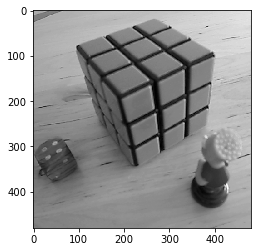

In [4]:
img = readrgb('cube3.png')[:,50:480+50]
g = rgb2gray(img)
f = gray2float(g)
imshowg(g)

Preparamos la máscara de convolución de un filtro gaussiano.

0.9999999999999999


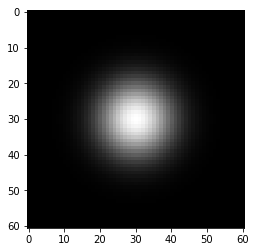

In [5]:
r = 30
x,y = dom((2*r+1,2*r+1),raw=True)

sigma = 10
psf = np.exp(-((x-r)**2+(y-r)**2)/sigma**2)
psf = psf/np.sum(psf)
print(np.sum(psf))
imshowx(psf)

Y la aplicamos a la imagen de entrada.

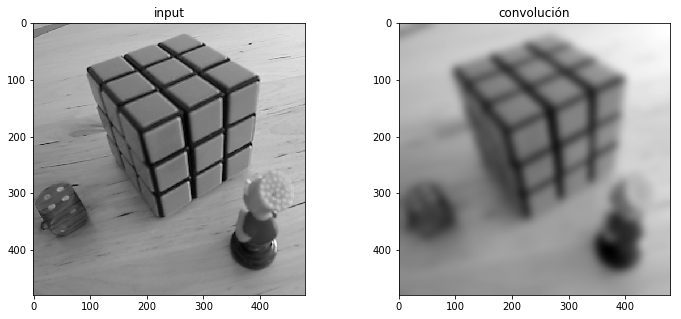

In [6]:
s = conv(psf,f)

fig(12,5)
subplot(1,2,1); imshowg(f); title('input')
subplot(1,2,2); imshowg(s); title('convolución');

El resultado es equivalente a una multiplicación elemento a elemento en el dominio de la frecuencia.

(0.9999999999999999+0j)


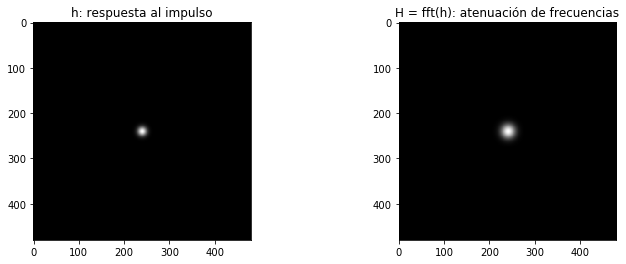

In [7]:
h = pad(psf,f.shape)

H = ft(center(h))

print(H.max())

fig(12,4)
subplot(1,2,1); imshowg(h) ; title('h: respuesta al impulso')
subplot(1,2,2); imshowg(center(abs(H))); title('H = fft(h): atenuación de frecuencias');

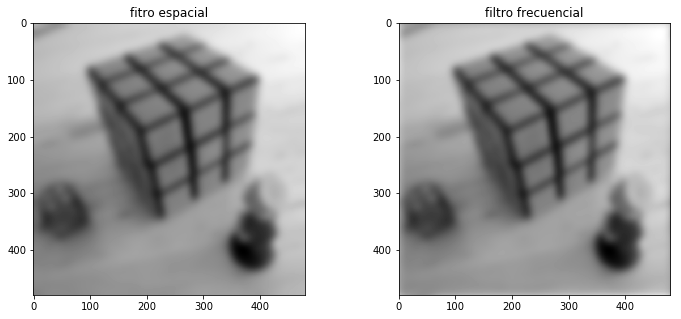

In [8]:
lp = np.real(ift(ft(f)*H))

fig(12,5)
subplot(1,2,1); imshowg(s);   title('fitro espacial')
subplot(1,2,2); imshowg(lp);  title('filtro frecuencial');

La diferencia entre las dos solo es apreciable cerca de los bordes. En realidad la convolución con máscaras grandes se implementa con la FFT.

La transformada de Fourier de una gaussiana de achura $\sigma$ es una gaussiana de anchura $1/\sigma$: cuanto mayor sea el emborronamiento más se atenuarán las altas frecuencias.

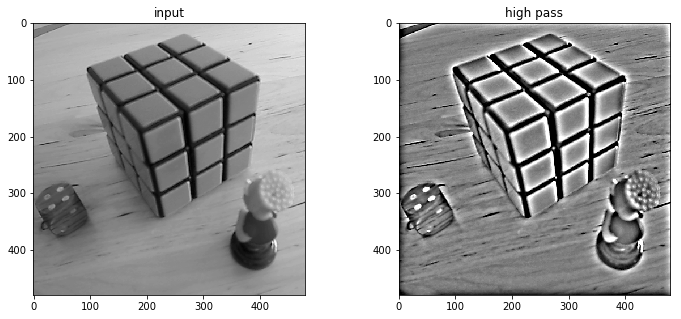

In [9]:
hp = np.real(ift(ft(f)*(1-H)))

fig(12,5)
subplot(1,2,1); imshowg(f); title('input')
subplot(1,2,2); imshows(hp,0.1); title('high pass');

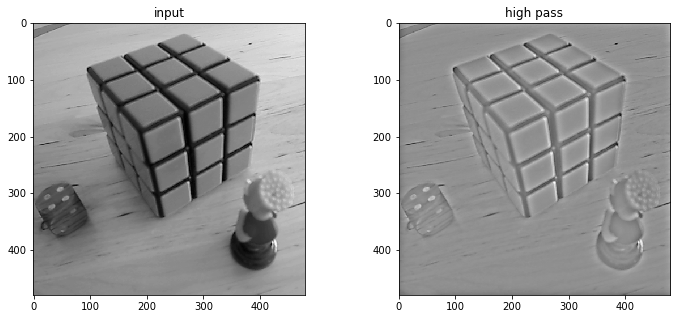

In [10]:
fig(12,5)
subplot(1,2,1); imshowg(f); title('input')
subplot(1,2,2); imshowg(hp); title('high pass');

## Filtrado inverso

En el dominio de la frecuencia, un filtro lineal es una multiplicación por H, la transformada de la máscara de convolución. Entonces, en principio, dividiendo por H se podría deshacer su efecto. Sería una "deconvolución". El problema es que H tenga ceros...

Cargamos una imagen para hacer los experimentos.

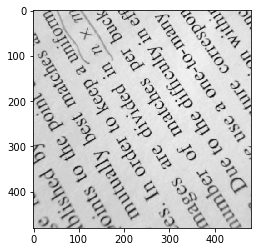

In [11]:
img = readrgb('texto/borroso0.png')[:,50:480+50]
g = rgb2gray(img)
f = gray2float(g)
imshowg(g)

Ahora elegimos una de las siguientes degradaciones.

0.9999999999999999


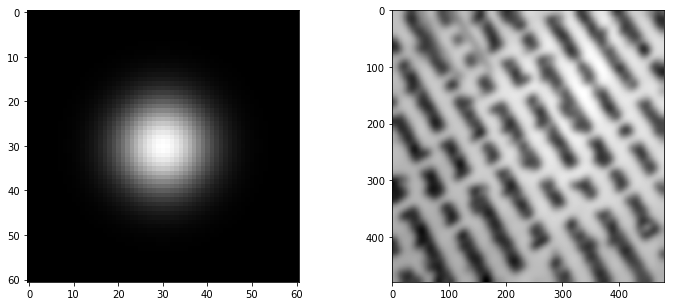

In [12]:
ejemplo = 1

# suavizado gaussiano
if ejemplo == 1:
    r = 30
    x,y = dom((2*r+1,2*r+1),raw=True)
    sigma = 10
    psf = np.exp(-((x-r)**2+(y-r)**2)/sigma**2)

# imagen doble
if ejemplo == 2:
    r = 10
    psf = np.zeros([2*r+1,2*r+1])
    psf[r,[r,r+10]] = 1
    psf = psf/np.sum(psf)

# imagen "movida" horizontalmente
if ejemplo == 3:
    r = 10
    psf = np.zeros([2*r+1,2*r+1])
    psf[r,:] = 1

psf = psf/np.sum(psf)
print(np.sum(psf))
    
s = conv(psf,f)

fig(12,5)
subplot(1,2,1); imshowx(psf)
subplot(1,2,2); imshowg(s)

Intentamos deshacer la degradación elegida. Para ello calculamos su FFT y calculamos la inversa, con cuidado de saturar los valores muy pequeños para que no se hagan infinitos.

En teoría es mejor usar el [filtro de Wiener](https://en.wikipedia.org/wiki/Wiener_deconvolution).

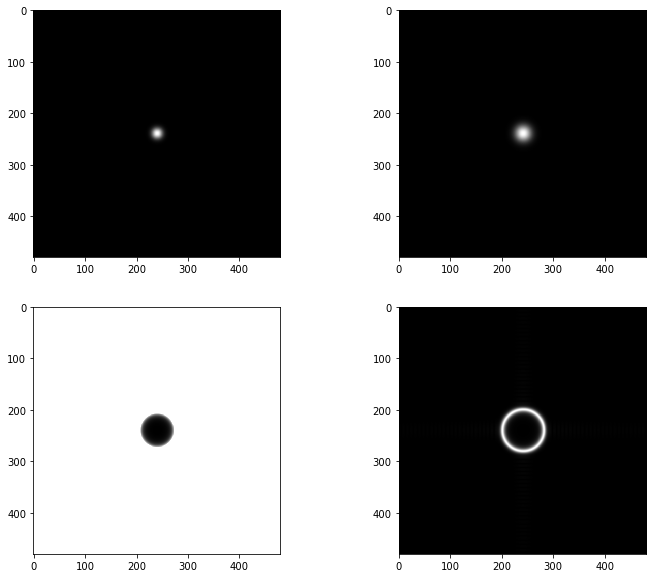

In [13]:
h = pad(psf,f.shape)

H = ft(center(h))

IH = invert(H,0.01)
       
IHW = wiener(pad(psf,f.shape),0.000001)       

fig(12,10)
subplot(2,2,1); imshowg(h)
subplot(2,2,2); imshowg(abs(center(H)))
subplot(2,2,3); imshowg(abs(center(IH)))
subplot(2,2,4); imshowg(abs(center(IHW)))

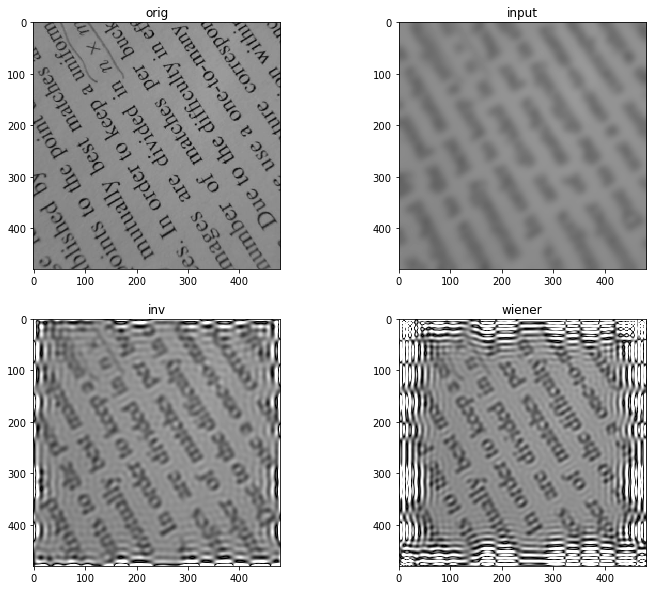

In [14]:
fig(12,10)
subplot(2,2,1); imshowf(f); title('orig')
subplot(2,2,2); imshowf(s); title('input')

subplot(2,2,3)
imshowf(abs(ift(ft(s)*IH)))
title('inv')

subplot(2,2,4)
imshowf(abs(ift(ft(s)*IHW)))
title('wiener');

El resultado no está mal pero es una situación poco realista: una degradación sintética y conocida.

## Imagen natural

Intentamos mejorar una imagen real desenfocada ópticamente. Sin demasiado éxito, tal vez porque la respuesta al impulso (su *point spread function*) no es una gaussiana ni la transformación invariante a desplazamientos, etc.

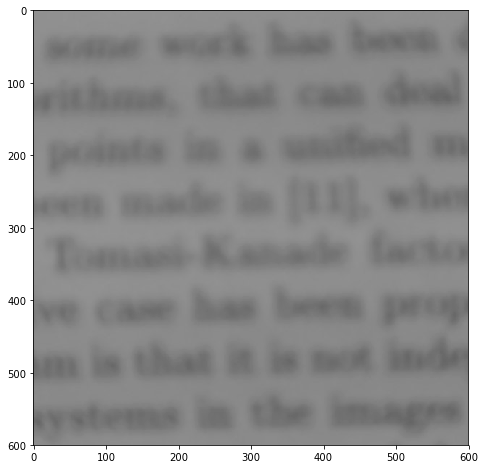

In [15]:
b = readrgb('texto/bo2.png')[100:700,150:750]
b = gray2float(rgb2gray(b))
fig(12,8)
imshow(b,'gray',vmin=0,vmax=1);

1.0


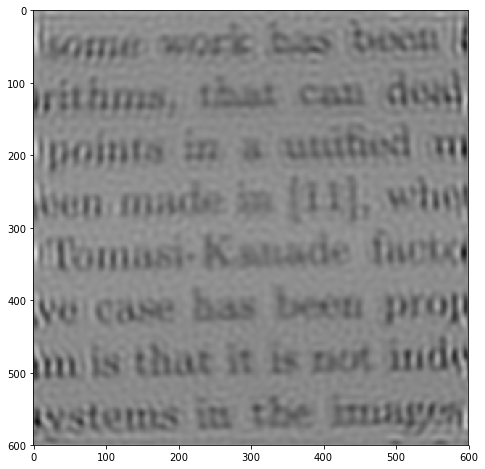

In [16]:
# radio de la máscara
r = 100
x,y = dom((2*r+1,2*r+1),raw=True)

# sigma que suponemos
sigma = 9
psf = np.exp(-((x-r)**2+(y-r)**2)/sigma**2)
psf = psf/np.sum(psf)
print(np.sum(psf))

IHW = wiener(pad(psf,b.shape),0.001)

rb = abs(ift(ft(b)*IHW))

fig(12,8)
imshowf(rb)

### Depuración

Hemos capturado la misma imagen pero mejor enfocada.

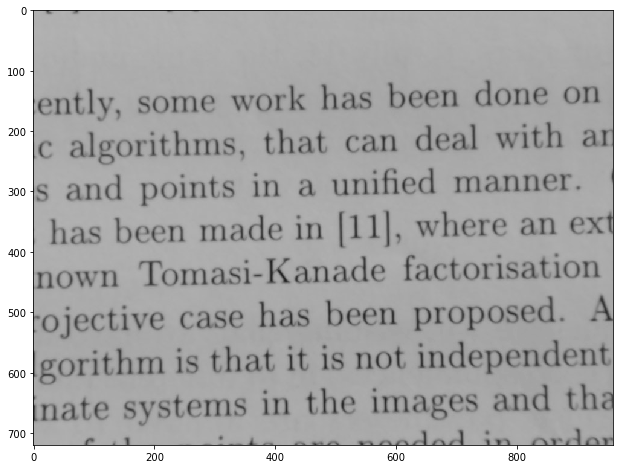

In [17]:
#b = readrgb('texto/borroso1.png')
b0 = readrgb('texto/bo0.png')
b0 = gray2float(rgb2gray(b0))
b = readrgb('texto/bo2.png')
b = gray2float(rgb2gray(b))

fig(12,8)
imshowf(b0)

Vamos a ver si al menos "a ojo" la imagen desenfocada y el suavizado gaussiano se parecen.

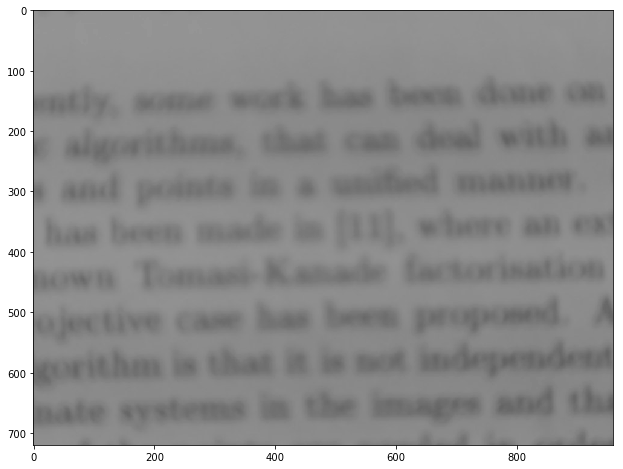

In [18]:
fig(12,8)
imshowf(b)

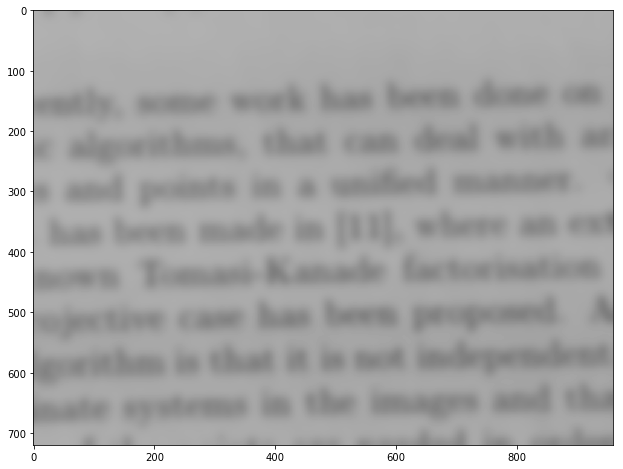

In [19]:
gb = cv.GaussianBlur(b0,(-1,-1),8)

fig(12,8)
imshowf(gb)

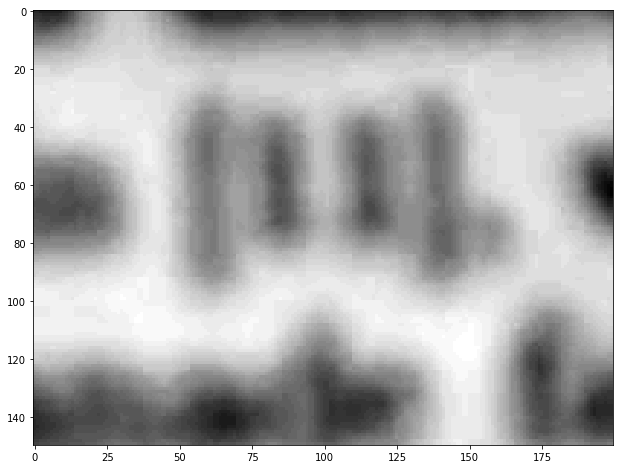

In [20]:
fig(12,8)
imshow(b[300:450,450:650],'gray');

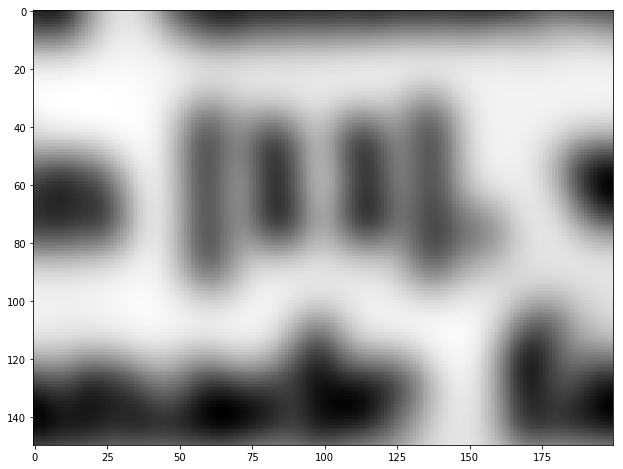

In [21]:
fig(12,8)
imshow(gb[300:450,450:650],'gray');

La imagen original está bastante pixelada en comparación con la sintética, pero se parecen bastante.

Vamos a comparar el resultado del filtrado inverso con la imagen enfocada.

1.0


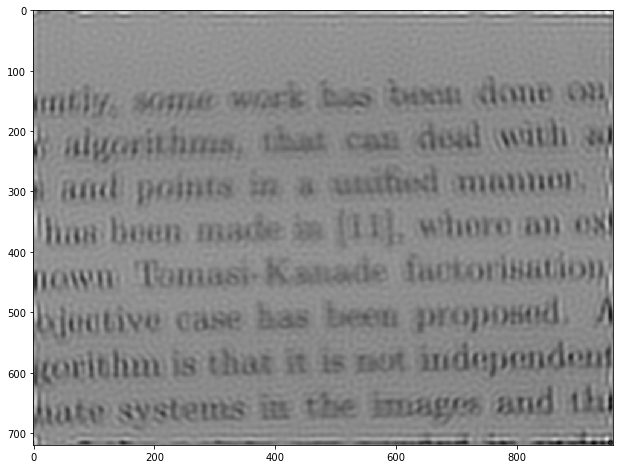

In [22]:
r = 100
x,y = dom((2*r+1,2*r+1),raw=True)

sigma = 8
psf = np.exp(-((x-r)**2+(y-r)**2)/sigma**2)
psf = psf/np.sum(psf)
print(np.sum(psf))

IHW = wiener(pad(psf,b.shape),0.001)

rb = abs(ift(ft(b)*IHW))

fig(12,8)
#subplot(1,2,1); imshowg(b)
#subplot(1,2,2); imshowf(abs(ift(ft(b)*IHW)))
imshowf(rb)

Ampliamos:

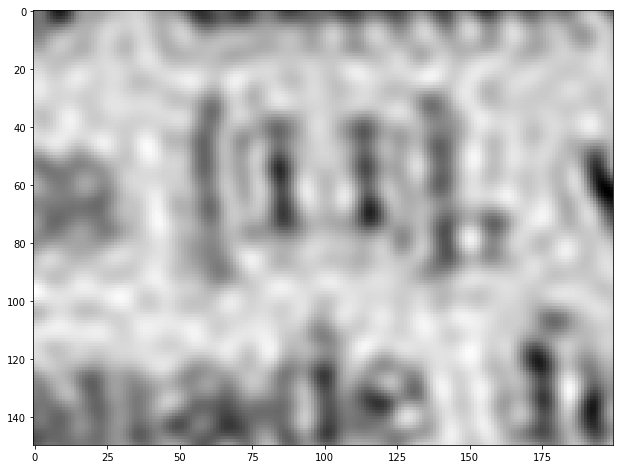

In [23]:
fig(12,8)
imshow(rb[300:450,450:650],'gray');

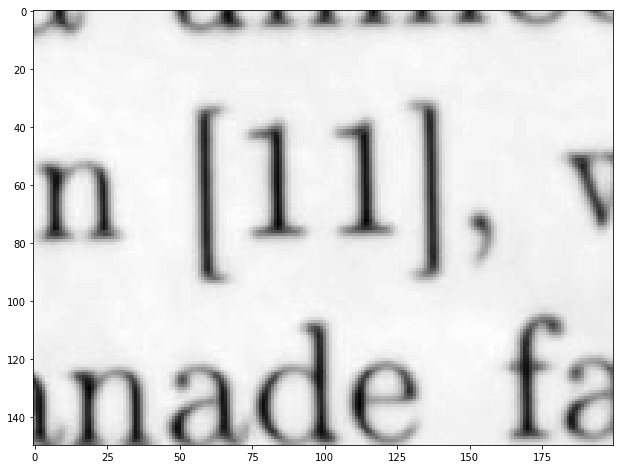

In [24]:
fig(12,8)
imshow(b0[300:450,450:650],'gray');

Hay que investigar más este tema...

- [Inverse filtering](http://yuzhikov.com/articles/BlurredImagesRestoration1.htm)


- [Wiener](https://www.cis.rit.edu/class/simg782/lectures/lecture_16/lec782_05_16.pdf)